# Investigating the Length Scale of Bailer-Jones+18 distances

Recent work by [Bailer-Jones et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180410121B) (hereafter BJ+18) appropriately inferred distances to stars in the *Gaia* DR2 sample using Bayesian analysis involving applying a distance prior to the distance and finding the mode of the posterior distribution this generates. The prior uses a length scale $L > 0$ to describe the exponentially decreasing space density of targets. The justification for this prior can be found in [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015PASP..127..994B) (hereafter BJ15). All equations in this blog are from one of these two papers!

This in opposition to the more 'traditional' case of dividing 1 by the parallax to obtain distance, which does not hold true for targets with large parallax errors or negative parallaxes, which are nonetheless valid astrometric solutions.

The work in BJ+18 uses *Galaxia* models subdivided into cells across the sky to fit for a value of $L$, before interpolating these values across the sky to find the length scale $L(l,b)$ as a function of galactic latitude and longitude.

This blog aims to investigate the validity of these length scales by using [TRILEGAL](http://stev.oapd.inaf.it/cgi-bin/trilegal) simluations to investigate how the length scale varies depending on stellar type, and how this affects the inferred distances to these targets.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

import pandas as pd
from astropy.table import Table
from tqdm import tqdm

import omnitool
from omnitool.literature_values import *

import sys

rerun = False

## Lets have a quick look at how the BJ+18 prior changes as a function of RA and Dec in Kepler

The below catalogue can be found [here](https://gaia-kepler.fun/])!

In [3]:
data = Table.read('../data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
kdf = data.to_pandas()
kdf.rename(columns={'kepid':'KICID'},inplace=True)
kdf.head(2)
print(len(kdf))

195830


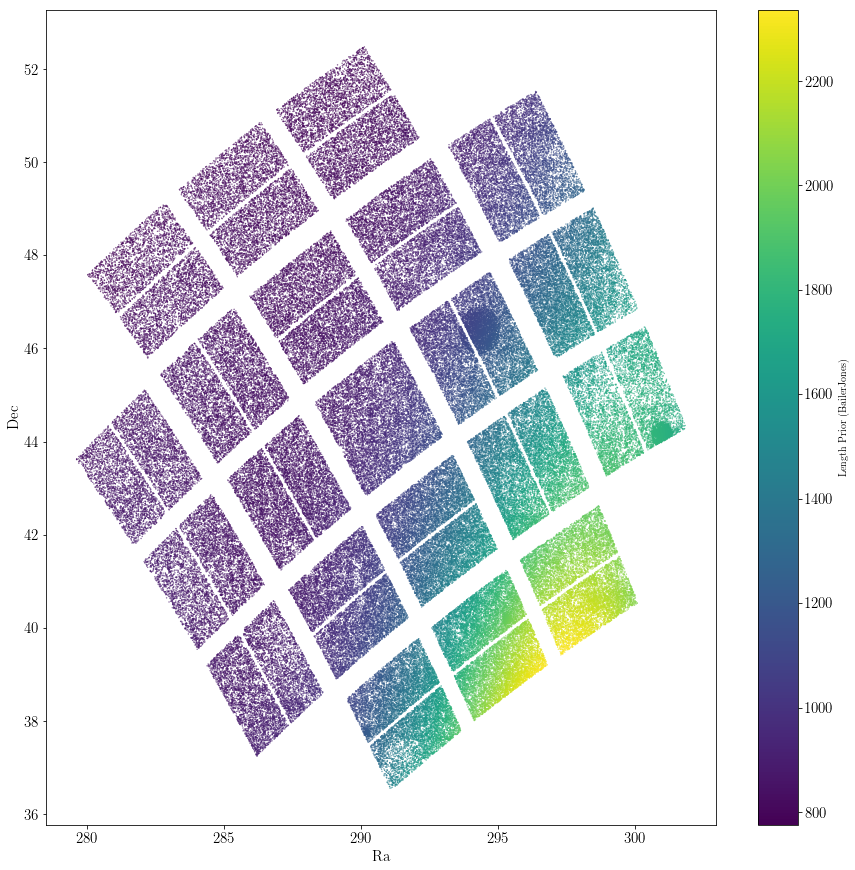

In [45]:
fig, ax = plt.subplots(figsize=(15,15))
c = ax.scatter(kdf.ra, kdf.dec,s=0.1,c=kdf.r_length_prior)
fig.colorbar(c,label='Length Prior (BailerJones)')
ax.set_xlabel('Ra',fontsize=15)
ax.set_ylabel('Dec',fontsize=15)
plt.show()

### Now lets investigate these values for an exclusively RC sample, as idenitfied in [Yu+18](http://adsabs.harvard.edu/abs/2018arXiv180204455Y)

In [21]:
def read_data():
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df
yu18 = read_data()
print(len(yu18))

7725


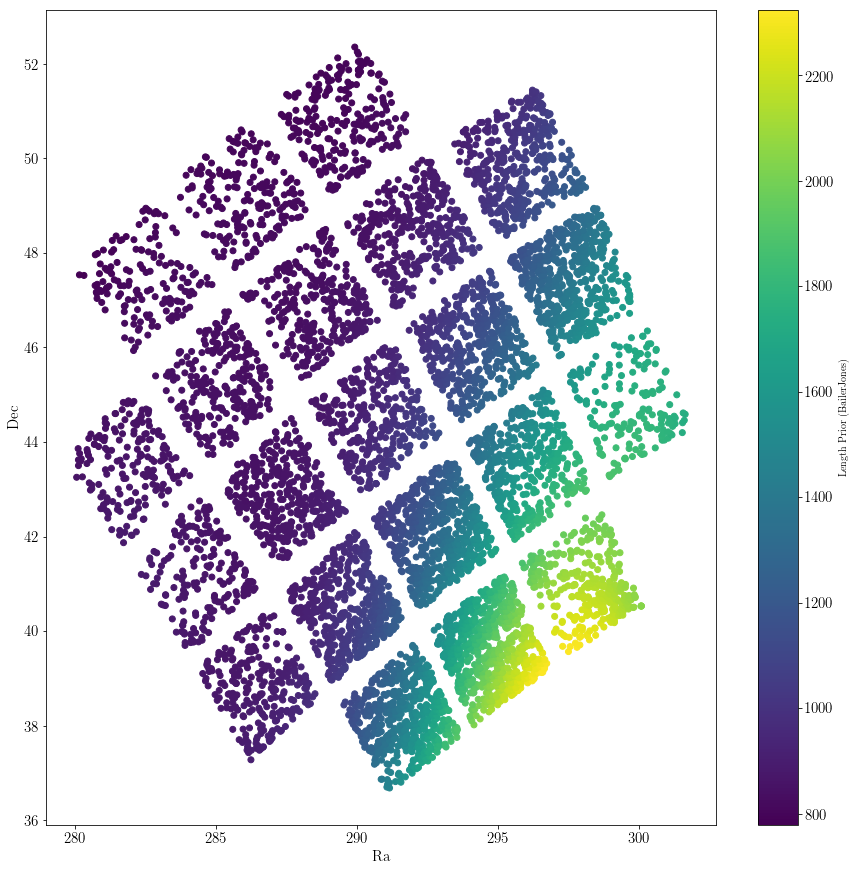

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
c = ax.scatter(yu18.ra, yu18.dec,c=yu18.r_length_prior)
fig.colorbar(c,label='Length Prior (BailerJones)')
ax.set_xlabel('Ra',fontsize=15)
ax.set_ylabel('Dec',fontsize=15)
plt.show()

As expected, there appears to be no offset unique to Red Clump stars. This is further illustrated in the below plot:

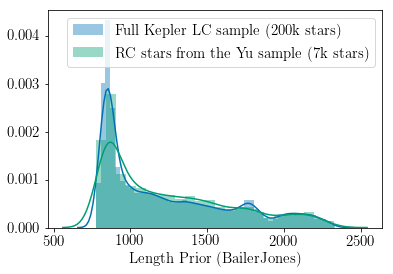

In [47]:
sns.distplot(kdf.r_length_prior,label='Full Kepler LC sample (200k stars)')
sns.distplot(yu18.r_length_prior,label='RC stars from the Yu sample (7k stars)')
plt.legend(fontsize=15)
plt.xlabel('Length Prior (BailerJones)',fontsize=15)
plt.show()

Thus we can confirm that in the catalogue published by BJ+18, there is no evident separate treatement of the distance prior for Red Clump stars. This is expected, as BJ+18 calculate $L(l,b)$ as a function of galactic position, but its good to check anyway before proceeding to the next step.

## Now lets investigate which values of L are appropriate for different stellar types using TRILEGAL

In [23]:
tdf = pd.read_csv('../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep='\s+')
tdf['Ak'] = omnitool.literature_values.Av_coeffs['Ks'].values[0]*tdf.Av
tdf['MK'] = tdf.Ks - tdf['m-M0'] - tdf.Ak
tdf['dist'] = 10.0**(tdf['m-M0'] / 5.0 + 1.0)

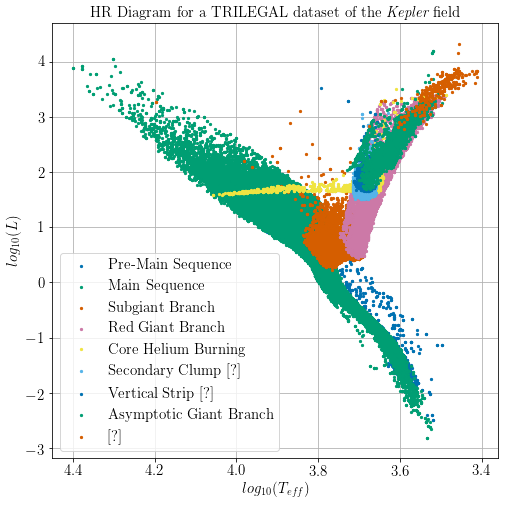

In [48]:
m_ks = tdf['Ks'].values
mu = tdf['m-M0'].values
Av = tdf['Av'].values
M = tdf['Mact'].values
labels =tdf['stage'].values
Zish = tdf['[M/H]'].values
logT = tdf['logTe'].values
logL = tdf['logL'].values

fig, ax = plt.subplots(figsize=(8,8))
label = ['Pre-Main Sequence', 'Main Sequence', 'Subgiant Branch', 'Red Giant Branch', 'Core Helium Burning',\
            'Secondary Clump [?]', 'Vertical Strip [?]', 'Asymptotic Giant Branch','[?]']
for i in range(int(np.nanmax(labels))+1):
    ax.scatter(logT[labels==i],logL[labels==i],s=5,label=label[i])
ax.legend(loc='best',fancybox=True,fontsize=15)
ax.invert_xaxis()
ax.set_xlabel(r"$log_{10}(T_{eff})$",fontsize=15)
ax.set_ylabel(r'$log_{10}(L)$',fontsize=15)
ax.set_title(r"HR Diagram for a TRILEGAL dataset of the $\textit{Kepler}$ field",fontsize=15)
ax.grid()
ax.set_axisbelow(True)
plt.show(fig)


Just to clarify, there are a couple of stellar classifications in there that I am uncertain of, and given the label '\[?\]'. However due to to their position in the HR Diagram I have taken the liberty of classifying them as giant stars. Not also that despite the colour similarities, the stars at the high end of the giant branch do not belong to the subgiant population.

We'll plot below the distribution of TRILEGAL distances for different stellar groups, namely 'Giants' (everything RGB and later) and 'Dwarfs' (main sequence stars). Subgiants and pre-MS stars have been excluded. Post-giant stars are not included in the simulation.

In [37]:
giantmask = tdf.stage >= 3.
dwarfmask = tdf.stage == 1.

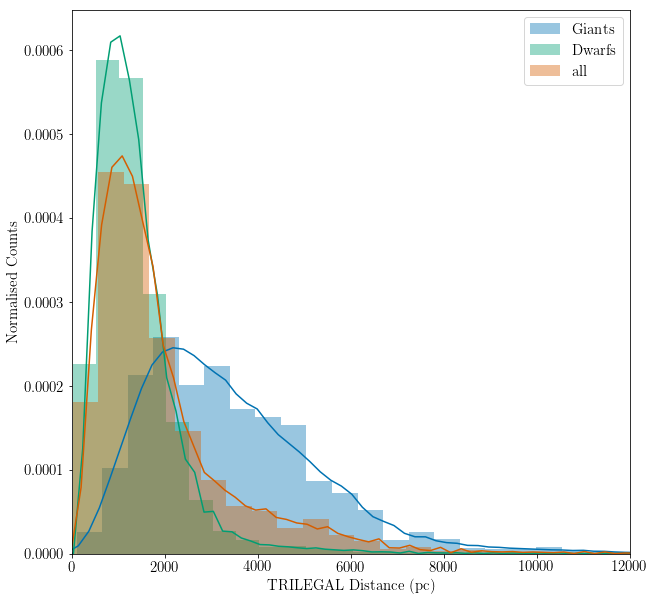

In [88]:
fig = plt.figure(figsize=(10,10))
sns.distplot(tdf.dist[giantmask],label='Giants')
sns.distplot(tdf.dist[dwarfmask],label='Dwarfs')
sns.distplot(tdf.dist, label='all')
plt.ylabel('Normalised Counts',fontsize=15)
plt.xlabel('TRILEGAL Distance (pc)',fontsize=15)
plt.xlim(0, 12000)
plt.legend(fontsize=15)
plt.show()

I have applied a limit on the plot at $12 kpc$ for clarity. Clearly, the distribution of distances is different for different stellar types, as we'd expect from their differing luminosity functions.

#### We'll use a simple PyStan model to fit the BJ15 distance prior to the data and find a length scale L appropriate for these stellar groups.

This **exponentially decreasing space density** distance prior, as found in Bailer-Jones15, described further in Bailer-Jones+18, and applied in Pystan in Hawkins+17, goes as

### $P(r | L) = \frac{1}{2L^3}r^2e^{-r/L}$,
for $r > 0$ and 0 everywhere else, where L is a length scale.

I have chosen to apply a uninformative uniform prior on $L$ ranging from $0.1pc$ to $4kpc$.

In [61]:
import pystan
lmodel = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower=0> N;
    real r[N];
}
parameters {
    real<lower=.1, upper=4000.> L;
}
model {
    for (n in 1:N){
        r[n] ~ bailerjones(L);
    }
}
'''
if rerun:
    sm = pystan.StanModel(model_code=lmodel, model_name='lmodel')
else:
    pass

##### Giant stars

In [62]:
if rerun:
    d = tdf.dist[giantmask].values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

In [63]:
if rerun:
    L_giant = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_giant = 1154.42

##### Dwarf stars

In [64]:
if rerun:
    d = tdf.dist[dwarfmask].values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

In [65]:
if rerun:
    L_dwarf = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_dwarf = 452.13

##### Full sample

In [66]:
if rerun:
    d = tdf.dist.values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

In [67]:
if rerun:
    L_all = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_all = 638.7

#### Now lets look at the results!

In [68]:
def bjl(r, L):
    return (1/(2*L**3)) * (r*r) * np.exp(-r/L);

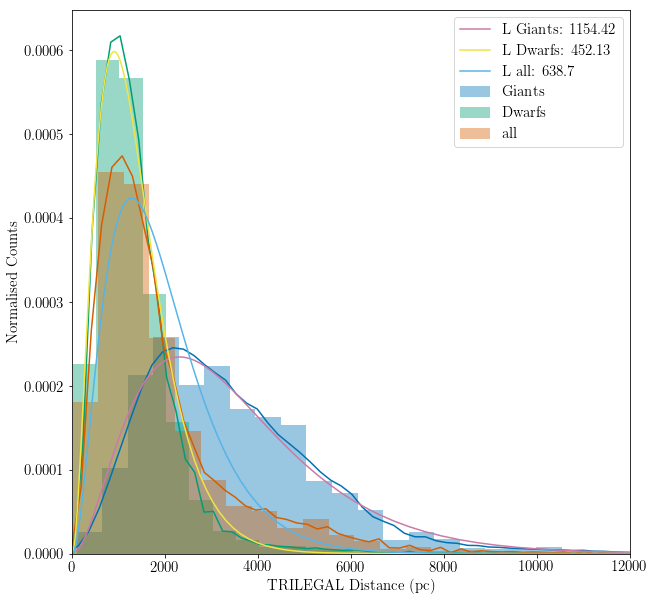

In [89]:
fig = plt.figure(figsize=(10,10))
sns.distplot(tdf.dist[giantmask],label='Giants')
sns.distplot(tdf.dist[dwarfmask],label='Dwarfs')
sns.distplot(tdf.dist, label='all')
plt.plot(np.sort(tdf.dist[giantmask]), bjl(np.sort(tdf.dist[giantmask]),L_giant),label='L Giants: '+str(np.round(L_giant,2)))
plt.plot(np.sort(tdf.dist[dwarfmask]), bjl(np.sort(tdf.dist[dwarfmask]),L_dwarf),label='L Dwarfs: '+str(np.round(L_dwarf,2)))
plt.plot(np.sort(tdf.dist), bjl(np.sort(tdf.dist), L_all),label='L all: '+str(np.round(L_all,2)))

plt.ylabel('Normalised Counts',fontsize=15)
plt.xlabel('TRILEGAL Distance (pc)',fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0., 12000)
plt.show()

In the Figure it appears that the distribution matches well to dwarf stars and to giant stars separately, but struggles to find a clean fit for the full sample.

The value of L also differs by close to a factor of 3 between the two stellar groups, and by a factor of 2 from the value found from a fit to the full set of data.

This is important, as the work by BJ+18 describes the calculation of L as being done for patches of sky, but not for different stellar groups.

## Lets investigate how this changes the posterior distributions that distance estimates are drawn from

If we assume parallax values to be distributed normally as $N(\varpi | 1/r, \sigma_{\varpi})$, then given the prior on distance and Bayes equation, we can find the ($\textbf{unnormalised!}$) posterior over the distance to be (as seen in BJ+18):

### $P^*(r | \varpi, \sigma_\varpi, L) = r^2 \exp\bigg[-\frac{r}{L} - \frac{1}{2\sigma^2_\varpi} \bigg(\varpi - \frac{1}{r}\bigg)^2\bigg]$ 
for $r > 0$, and 0 everywhere else.

Note that I have made some changes from the version given in BJ+18; L is no longer a function of galactic position, and I have omitted the global parallax zeropoint $\varpi_{zp}$ as I am working with simulated data.

I should probably note that TRILEGAL provides distance modulus and not parallax, so my synthetic parallaxes will be generated as $1/r$, and uncertainties will be inserted at the parallax level. This doesn't matter for what we're doing, as we want to see the $\textbf{quantitative}$ difference a change in $L$ and $\sigma_\varpi$ make to the esitmated distance.

In [75]:
def postprob_un(r, L, oo, oo_err):
    return r**2 * np.exp(-(r/L) - (1/(2*oo_err**2))*(oo - (1./r))**2)

In [76]:
r = np.linspace(0., 10000, 100000)
tdf['oo'] = 1/tdf.dist
tdf['oo_err'] = .1*tdf.oo

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


Parallax: 1.096478196143185 mas
Error: 0.5482390980715925 mas == 50.0%


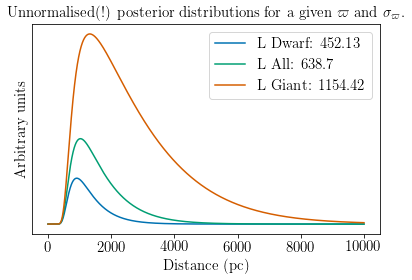

In [84]:
def plot_postprob_un(r, L_dwarf, L_all, L_giant, oo, oo_err):
    fig = plt.figure()
    plt.plot(r,postprob_un(r, L_dwarf, oo, oo_err),label='L Dwarf: '+str(np.round(L_dwarf,2))) 
    plt.plot(r,postprob_un(r, L_all, oo, oo_err),label='L All: '+str(np.round(L_all,2)))
    plt.plot(r,postprob_un(r, L_giant, oo, oo_err),label='L Giant: '+str(np.round(L_giant,2)))
    plt.plot(label='Test')
    plt.title(r'Unnormalised(!) posterior distributions for a given $\varpi$ and $\sigma_\varpi$.',fontsize=15)
    plt.xlabel('Distance (pc)',fontsize=15)
    plt.ylabel('Arbitrary units',fontsize=15)
    plt.yticks([])
    fig.tight_layout()
    plt.legend(fontsize=15)
    print('Parallax: '+str(1000*oo)+' mas')
    print('Error: '+str(1000*oo_err)+' mas == '+str(oo_err*100/oo)+'%')
plot_postprob_un(r, L_dwarf, L_all, L_giant, tdf.oo[0], tdf.oo_err[0]*5)

As expected, the shape of the posterior is very different to a Gaussian distribution for uncertain targets, and thus the $1/r$ transformation does not hold for these objects.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


Parallax: 1.096478196143185 mas
Error: 0.10964781961431852 mas == 10.0%


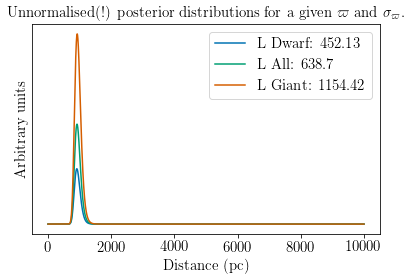

In [85]:
plot_postprob_un(r, L_dwarf, L_all, L_giant, tdf.oo[0], tdf.oo_err[0])

As you can see, if we decrease the uncertainty, the result becomes a lot more constrained, the modes of the posteriors for different L are closer, and the posteriors tend towards a normal distribution in the limit that $\sigma_\varpi \rightarrow 0.$

As stated in BJ+18:
>While the posterior\[s\] \[above\] \[are\] the complete description of the distance to the source, we often want to use a single point estimate along with some measure of the uncertainty. \[...\] As the point estimator $r_{est}$, we prefer here the mode, $r_{mode}$. This is found analytically by solving a cubic equation.

This cubic equation can be found by setting $P^*(r | \varpi, \sigma_\varpi, L)/dr = 0$, which gives

### $\frac{r^3}{L} - 2r^2 + \frac{\varpi}{\sigma_\varpi^2}r - \frac{1}{\sigma_\varpi^2} = 0$

We evaluate this using $\texttt{numpy.roots}$ in this blog, and employ the following evaluation criteria given in BJ15:

>Inspection of the roots leads to the following strategy for assigning the distance estimator \[...\] from the modes:
- If there is one real root, it is a maximum: select this as the mode.
- If there are three real roots, there are two maxima:
 -  If $\varpi \geq 0$, select the smallest root as the mode.
 - If $\varpi < 0$, select the mode with r > 0 (there is only one).
 
Note that the latter is not relevant to this test, as we do not have any negative parallax in the sample. I've nonetheless included the criterion in the code in case anybody wants to apply it elsewhere.

We will be calculating $r_{mode}$ for each star in the TRILEGAL sample using each of the values of L, and for a range of parallax uncertainties.

In [90]:
def get_roots(L, oo, oo_err):
    p = np.array([1./L, -2, oo/oo_err**2., -1./oo_err**2.])
    roots = np.roots(p)
    if len(roots) == 1:
        return float(roots[0])
    if len(roots) == 3:
        if oo >= 0.:
            return float(np.min(roots[np.isreal(roots)]))
        if oo < 0.:
            return float(roots[np.isreal(roots)][roots > 0])
    else:
        print('You shouldnt be here, printing roots below for diagnostic:')
        print(roots)
        
def get_modes(L, oo, oo_err):
    return np.array([get_roots(L, o, err) for o, err in zip(oo, oo_err)])

In [91]:
idf = pd.DataFrame()

Ls = {'all':L_all,
    'dwarfs':L_dwarf,
    'giants':L_giant}
types = ['all','dwarfs','giants']

errange = np.arange(.05,.55,.05)

for ltype in types:
    for err in tqdm(errange):
        label='r_'+ltype+'_'+str(np.round(err,2))
        idf[label] = get_modes(Ls[ltype], tdf.oo, tdf.oo*err)
idf['oo'] = tdf.oo
idf['oo_err'] = tdf.oo_err
idf.sort_values('r_true', inplace=True)
idf.head(5)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
100%|██████████| 10/10 [03:29<00:00, 21.00s/it]


,r_all_0.05,r_all_0.1,r_all_0.15,r_all_0.2,r_all_0.25,r_all_0.3,r_all_0.35,r_all_0.4,r_all_0.45,r_all_0.5,...,r_giants_0.05,r_giants_0.1,r_giants_0.15,r_giants_0.2,r_giants_0.25,r_giants_0.3,r_giants_0.35,r_giants_0.4,r_giants_0.45,r_giants_0.5
0,913.314268,917.212854,923.667972,932.603852,943.891989,957.333194,972.642577,989.444745,1007.286210,1025.667644,...,914.780914,923.228336,937.778572,959.187261,988.608391,1027.673924,1078.523991,1143.601068,1224.786253,1321.422705
1,913.314268,917.212854,923.667972,932.603852,943.891989,957.333194,972.642577,989.444745,1007.286210,1025.667644,...,914.780914,923.228336,937.778572,959.187261,988.608391,1027.673924,1078.523991,1143.601068,1224.786253,1321.422705
2,956.196285,959.789368,965.715168,973.871027,984.098067,996.171345,1009.795016,1024.607503,1040.199854,1056.146294,...,957.803166,966.364258,981.074784,1002.634936,1032.093385,1070.889316,1120.825166,1183.806891,1261.047504,1351.525556
3,1583.001886,1577.515200,1568.941749,1557.981188,1545.378942,1531.816452,1517.853729,1503.915186,1490.301207,1477.210461,...,1587.377186,1594.819093,1607.181358,1624.377069,1646.234719,1672.453588,1702.559068,1735.873887,1771.524644,1808.497165
4,726.006271,730.744778,738.730829,750.083979,764.939950,783.407350,805.498461,831.034634,859.547018,890.222887,...,726.934853,734.593847,747.927770,767.895748,796.083722,835.027674,888.736139,963.320256,1066.644115,1202.757321


## Now lets make some illustrative plots!

In [ ]:
bisector = np.linspace(idf['r_true'].min(), idf['r_true'].max(), 10)

### First, lets see how the estimated mode distance compares to the 'true' TRILEGAL distance for each length scale, for various fractional uncertainties

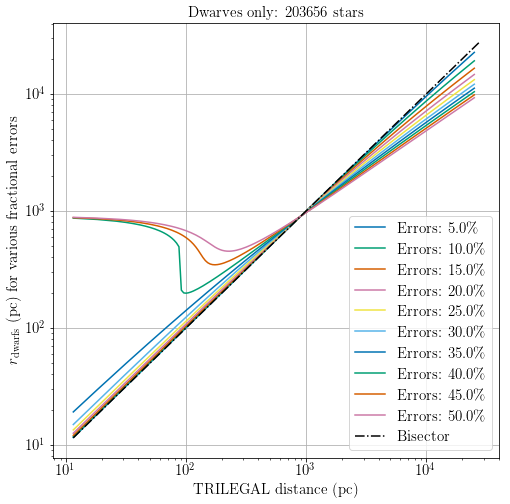

In [199]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.loglog(idf['r_true'][dwarfmask],idf['r_dwarfs_'+str(np.round(err,2))][dwarfmask],label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.plot(bisector,bisector,linestyle='-.',c='k',label='Bisector')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$r_{\rm dwarfs}$ (pc) for various fractional errors',fontsize=15)
plt.title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

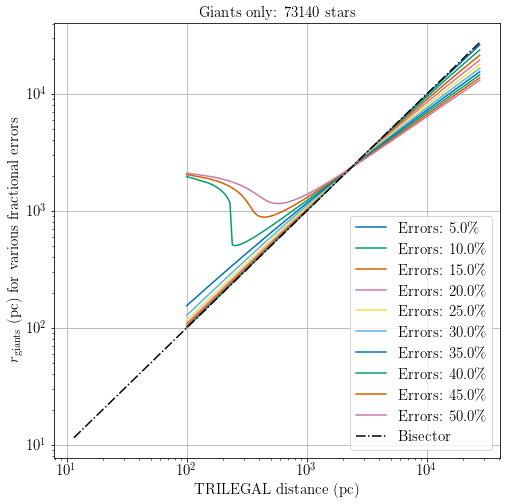

In [168]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.loglog(idf['r_true'][giantmask],idf['r_giants_'+str(np.round(err,2))][giantmask],label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.plot(bisector,bisector,linestyle='-.',c='k',label='Bisector')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$r_{\rm giants}$ (pc) for various fractional errors',fontsize=15)
plt.title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()

plt.show()

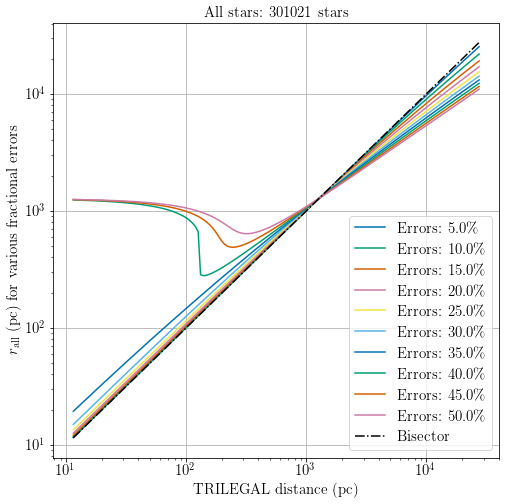

In [167]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.loglog(idf['r_true'],idf['r_all_'+str(np.round(err,2))],label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.plot(bisector,bisector,linestyle='-.',c='k',label='Bisector')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$r_{\rm all}$ (pc) for various fractional errors',fontsize=15)
plt.title('All stars: '+str(len(idf['r_true']))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()

plt.show()

### Now, lets look at how the choice of L changes the distance residuals

We'll compare $r_{dwarfs}$ and $r_{giants}$ to the 'true' TRILEGAL distance $r_{true} respectively, and will plot the fractional difference in radius, ie:

### $\Delta_{true, dwarfs} = \frac{r_{dwarfs} - r_{true}}{r_{true}}$

In [181]:
idf['r_true'] = tdf['dist']
for err in tqdm(errange):
    idf['d_true_dwarfs_'+str(np.round(err,2))] = (idf['r_dwarfs_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']
    idf['d_true_giants_'+str(np.round(err,2))] = (idf['r_giants_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']
    idf['d_true_all_'+str(np.round(err,2))] = (idf['r_all_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']

100%|██████████| 10/10 [00:00<00:00, 124.93it/s]


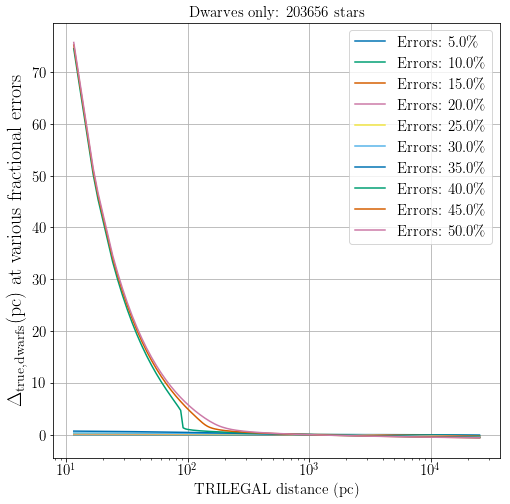

In [201]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.semilogx(idf['r_true'][dwarfmask]\
             ,idf['d_true_dwarfs_'+str(np.round(err,2))][dwarfmask]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$\Delta_{\rm true, dwarfs}$(pc) at various fractional errors',fontsize=20)
plt.title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

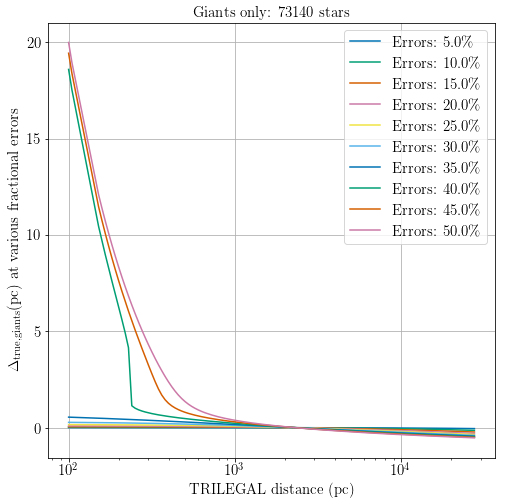

In [196]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.semilogx(idf['r_true'][giantmask]\
             ,idf['d_true_giants_'+str(np.round(err,2))][giantmask]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$\Delta_{\rm true, giants}$(pc) at various fractional errors',fontsize=15)
plt.title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

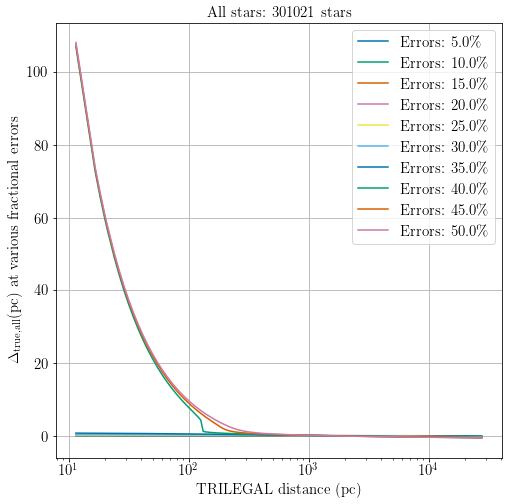

In [195]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.semilogx(idf['r_true']\
             ,idf['d_true_all_'+str(np.round(err,2))]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$\Delta_{\rm true, all}$(pc) at various fractional errors',fontsize=15)
plt.title('All stars: '+str(len(idf['r_true']))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

From this it appears that the resulting distance estimates come close (<10% for $\sigma_\varpi <$ 20%) to the the true value, when applying the appropriate  to the 

### Finally, lets look at how the choice of L affects the estimated mode distance
To make a more realstic comparison to the way distances are found in BJ+18, let's compare the estimated mode distances obtained through our length scales for dwarves and giants, to the distances obtained using the length scale fit for the full sample.

We'll compare $r_{all}$ to $r_{dwarfs}$ and $r_{giants}$ respectively, and will plot the fractional difference in radius, ie:

### $\Delta_{dwarfs} = \frac{r_{dwarfs} - r_{all}}{r_{all}}$

In [175]:
idf['r_true'] = tdf['dist']
for err in tqdm(errange):
    idf['d_dwarfs_'+str(np.round(err,2))] = (idf['r_dwarfs_'+str(np.round(err,2))] - idf['r_all_'+str(np.round(err,2))])/idf['r_all_'+str(np.round(err,2))]
    idf['d_giants_'+str(np.round(err,2))] = (idf['r_giants_'+str(np.round(err,2))] - idf['r_all_'+str(np.round(err,2))])/idf['r_all_'+str(np.round(err,2))]

100%|██████████| 10/10 [00:00<00:00, 178.62it/s]


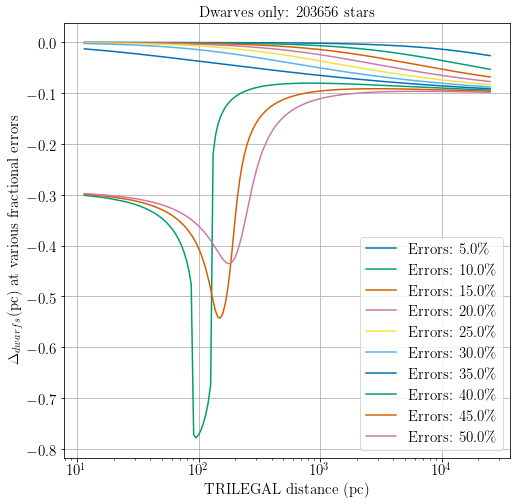

In [176]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.semilogx(idf['r_true'][dwarfmask]\
             ,idf['d_dwarfs_'+str(np.round(err,2))][dwarfmask]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$\Delta_{dwarfs}$(pc) at various fractional errors',fontsize=15)
plt.title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

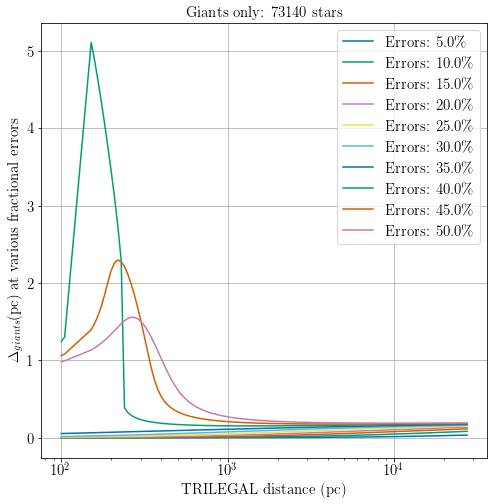

In [178]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.semilogx(idf['r_true'][giantmask]\
             ,idf['d_giants_'+str(np.round(err,2))][giantmask]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$\Delta_{giants}$(pc) at various fractional errors',fontsize=15)
plt.title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

### Lets have a quick investigation of those stars with extremely high residuals before moving on

In [211]:
sel = (idf['r_true'] < 150) & (idf['r_true'] >120)

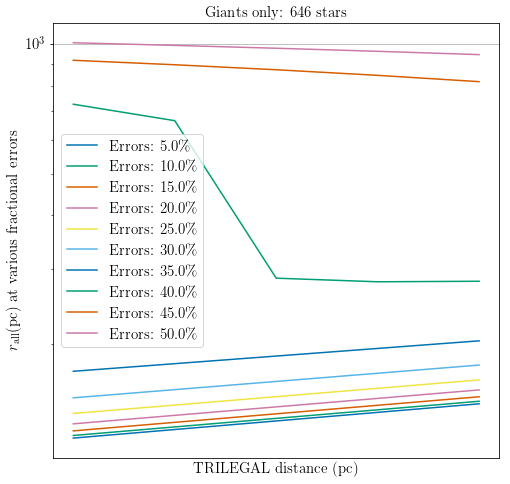

In [212]:
fig = plt.figure(figsize=(8,8))
for err in errange:
    plt.loglog(idf['r_true'][sel]\
             ,idf['r_all_'+str(np.round(err,2))][sel]\
             ,label='Errors: '+str(np.round(err,2)*100)+'\%')
plt.xlabel('TRILEGAL distance (pc)',fontsize=15)
plt.ylabel(r'$r_{\rm all}$(pc) at various fractional errors',fontsize=15)
plt.title('Giants only: '+str(len(idf['r_true'][sel]))+' stars', fontsize=15)
plt.legend(loc='best',fancybox=True,fontsize=15)
plt.grid()
plt.show()

In [213]:
test = tdf[sel]
len(test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


646

In [ ]:
oo = 

plot_postprob_un(r, L_dwarf, L_all, L_giant, tdf.oo[0], tdf.oo_err[0])